# 05_분류성능평가지표_실습

### 목차

#### 1. 실습데이터diabetes.csv파일 불러오고 Train / Test 나누기

#### 2 .Train Set을 이용한 Cross Validation + Grid search

#### 3. 위에서 찾은 최적의 하이퍼파라미터로 Test set 예측 + ROC 그리기

#### 4. 가장 성능이 좋은 RandomForest 모델의 최적의 Threshold찾기

In [1]:
import warnings
warnings.filterwarnings('ignore')

 - 학습의 목표
 - 머신러닝의 분류모델을 이용하여, 여러가지 평가지표를 확인해보자
 - 데이터: 의학(당뇨병 여부 판단)

In [2]:
# 모델 임포트
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Binarizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, make_scorer

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

## 1. 실습데이터`diabetes.csv`파일 불러오고 Train / Test 나누기

In [3]:
diabates_df = pd.read_csv('./실습데이터/diabetes.csv')

In [4]:
diabates_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
diabates_df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [6]:
# Train Test 나누기
X = np.array(diabates_df.drop( ['Outcome'] , axis=1, inplace=False))
Y = np.array(diabates_df['Outcome'])

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

## 2 .Train Set을 이용한 Cross Validation + Grid search
> Train set을 활용해서 최적의 하이퍼 파라미터를 찾는것이 목표이다
   - Logistic
   - DecisionTree
   - RandomForest
   - LightGBM

##### Logistic

In [8]:
logistic = LogisticRegression()

# 로지스틱의 경우 파라매터가 없기 때문에
# GridSearchCV대신 cross_val_score 사용
logistic_grid = cross_val_score(logistic, 
                                X_train, Y_train, 
                                cv          = 3,
                                scoring     = make_scorer(roc_auc_score))

print("Cross Validation 결과 :", logistic_grid.mean())

Cross Validation 결과 : 0.7084892995340756


##### DesicionTree

In [9]:
decision_tree = DecisionTreeClassifier(random_state=123)

params = { 
    'criterion'         : ['gini', 'entropy'],
    'max_depth'         : [8, 10, 12],
    'min_samples_leaf'  : [8, 10, 12],
    'min_samples_split' : [1, 2, 3]
            }


decision_tree_grid = GridSearchCV(decision_tree, 
                                  cv          = 3, 
                                  param_grid  = params, 
                                  refit       = True,
                                  scoring     = make_scorer(roc_auc_score))

decision_tree_grid.fit(X_train, Y_train)

print(decision_tree_grid.best_params_)
print(decision_tree_grid.best_score_)


# 1
# {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 6, 'min_samples_split': 2}
# 0.670975808786754

# 2 
# {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2}
# 0.6718615915133328

# 3
# {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 2}
# 0.6899944720840243

# 4 
# {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 2} << 최적의 하이퍼 파라미터
# 0.6899944720840243

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 2}
0.6899944720840243


##### RandomForest

In [10]:
random_forest = RandomForestClassifier(random_state=123)

params = { 
    'n_estimators' : [200, 300, 400],
    'max_depth' : [12, 14, 16],
    'min_samples_leaf' : [2, 4, 6],
    'min_samples_split' : [1, 2, 4]
            }


random_forest_grid = GridSearchCV(random_forest, 
                                  cv          = 3, 
                                  param_grid  = params, 
                                  refit       = True,
                                  scoring     = make_scorer(roc_auc_score))
random_forest_grid.fit(X_train, Y_train)

print(random_forest_grid.best_params_)
print(random_forest_grid.best_score_)



# 1
# {'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 100}
# 0.7050317197083366

# 2
# {'max_depth': 12, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 200}
# 0.7074310984758746

# 3
# {'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
# 0.7204638184737688

# 4
# {'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
# 0.7204638184737688

# 5
# {'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}  < 최적의 하이퍼 파라미터
# 0.7204638184737688

{'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
0.7204638184737688


##### LightGBM

In [20]:
lightgbm = LGBMClassifier(random_state=123)

params = { 
    'n_estimators' : [200, 300, 400],
    'max_depth' : [4, 6, 8],
    'min_samples_leaf' : [1, 2],
    'min_samples_split' : [1, 2, 3]
}

LGBM_grid = GridSearchCV(lightgbm,
                         param_grid  = params,
                         cv          = 3,
                         refit       = True,
                         scoring     = make_scorer(roc_auc_score))

LGBM_grid.fit(X_train, Y_train)

print(LGBM_grid.best_params_)
print(LGBM_grid.best_score_)


# 1
# {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 400}
# 0.6966411329595408

# 2
# {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 300}
# 0.6942272763168286

# 3
# {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 300}
# 0.6942272763168286

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 300}
0.6942272763168286


 - AUC수치를 기준으로한 CrossValidation 결과, FandomForest의 AUC가 `0.7204638184737688`로 가장 좋았다.
 - 그렇다면 Train set으로 RandomForest를 학습하고, 그 학습기로 Test set을 예측하는 것이 정석 루트이다


###### 하지만, 나는 배우는 입장이니 위에서 사용한 모든 머신러닝을 사용해 ROC커브를 그려보자

## 3. 위에서 찾은 최적의 하이퍼파라미터로 Test set 예측 + ROC 그리기

##### Logistic

AUC는? : 0.8466235632183908


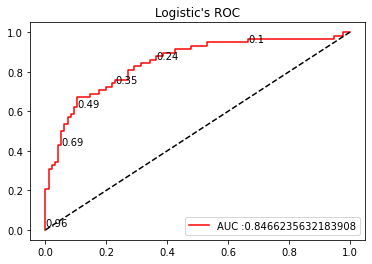

In [12]:
logistic.fit(X_train, Y_train)


# label이 1이 될 확률 담기
Y_prob = logistic.predict_proba(X_test)[:, 1]

# Threshold변화에 따른 fpr, tpr의 변화
fpr_array, tpr_array, threshold_array = roc_curve(Y_test, Y_prob)

# 그래프에 threshold를 표시하기위해 인덱스 추출
idx_list = np.arange(1, len(threshold_array), 10)


# ROC 그래프 그리기
plt.plot(fpr_array, tpr_array, 
         c = 'red', 
         label = "AUC :" + str(roc_auc_score(Y_test, Y_prob)))
plt.plot([0, 1], [0,1], ls='--', c='black')
plt.title("Logistic's ROC")
plt.legend(loc=0)
for idx in idx_list:
    text = str(round(threshold_array[idx], 2))
    plt.text(fpr_array[idx], tpr_array[idx], text)


# ROC의 auc는?
print('AUC는? :', roc_auc_score(Y_test, Y_prob))

##### DecisionTree

AUC는? : 0.8255208333333333


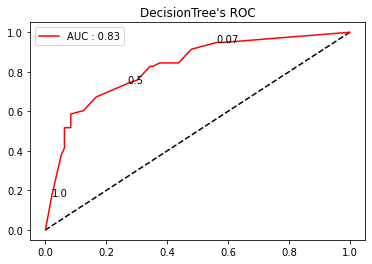

In [13]:
# label이 1이 될 확률 담기
Y_prob = decision_tree_grid.best_estimator_.predict_proba(X_test)[:,1]

# Threshold변화에 따른 fpr, tpr의 변화
fpr_array, tpr_array, threshold_array = roc_curve(Y_test, Y_prob)

# 그래프에 threshold를 표시하기위해 인덱스 추출
idx_list = np.arange(1, len(threshold_array), 10)

# ROC 그래프 그리기
plt.plot([1, 0], [1, 0], c='black', ls='--')
plt.plot(fpr_array, tpr_array, c='red', label='AUC : ' + str(roc_auc_score(Y_test, Y_prob)))
for idx in idx_list:
    text = str(round(threshold_array[idx], 2))
    plt.text(fpr_array[idx], tpr_array[idx], text)
plt.title("DecisionTree's ROC")
plt.legend(loc=0)

# ROC의 AUC는?
print('AUC는? :', roc_auc_score(Y_test, Y_prob))

##### RandomForest

AUC는? : 0.8586566091954023


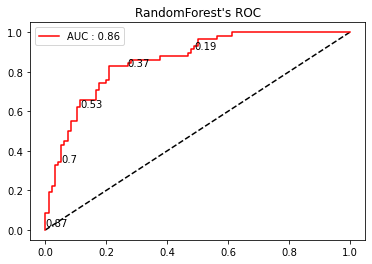

In [14]:
# label이 1이 될 확률 담기
Y_prob = random_forest_grid.best_estimator_.predict_proba(X_test)[:, 1]

# Threshold변화에 따른 fpr, tpr의 변화
fpr_array, tpr_array, threshold_array = roc_curve(Y_test, Y_prob)

# 그래프에 threshold를 표시하기위해 인덱스 추출
idx_list = np.arange(1, len(threshold_array), 10)

# ROC 그래프 그리기
plt.plot([1,0], [1, 0], ls='--', c='black')
plt.plot(fpr_array, tpr_array, c='red', label='AUC : ' + str(roc_auc_score(Y_test, Y_prob)))
for idx in idx_list:
    text = str(round(threshold_array[idx], 2))
    plt.text(fpr_array[idx], tpr_array[idx], text)
plt.title("RandomForest's ROC")
plt.legend(loc=0)

# ROC의 AUC는?
print('AUC는? :', roc_auc_score(Y_test, Y_prob))

##### lightGBM

AUC는? : 0.8371048850574713


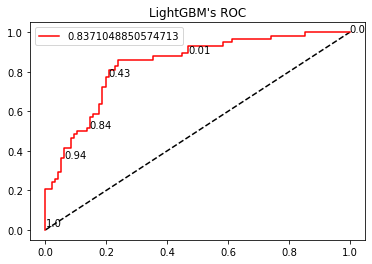

In [52]:
# label이 1이 될 확률 담디
Y_prob = LGBM_grid.best_estimator_.predict_proba(X_test)[:, 1]

# Threshhold 변화에 따른 fpr, tpr 변화
fpr_array, tpr_array, threshold_array = roc_curve(Y_test, Y_prob)

# 그래프에 threshold를 표시하기위해 인덱스 추출
idx_list = np.arange(1, len(threshold_array), 10)


plt.plot([0, 1], [0, 1], ls='--', c='black')
plt.plot(fpr_array, tpr_array, c='red', label=str(roc_auc_score(Y_test, Y_prob)))

# ROC 그래프 그리기
plt.title("LightGBM's ROC")
plt.legend(loc=0)
for idx in idx_list:
    text = str(round(threshold_array[idx], 2))
    plt.text(fpr_array[idx], tpr_array[idx], text)
    
print('AUC는? :', roc_auc_score(Y_test, Y_prob))

 - Test set을 예측하였을때, AUC수치가 가장 높은 모델은 `RandomForest`였다.
 - 이제 최적의 Threshold를 찾고 그 Threshold값을 사용하여 최종예측을 수행하자

## 4. 가장 성능이 좋은 RandomForest 모델의 최적의 Threshold찾고 최종예측하기

 - 사실 구현하고자 하는 목적에 따라 중요한 성능지표를 선정하고, 선정한 성능지표를 높이는 방향으로 진행하는 것이 좋다
 - 우리는 실습하는 것이 목적이기에, precision과 recall이 동일한 수치일때(precision과 recall이 동시에 가장 높을 수 있는 지점일때)의 Threshold를 찾고 그 Threshold값을 이용하여 최종 Test set 예측을 시행해보자

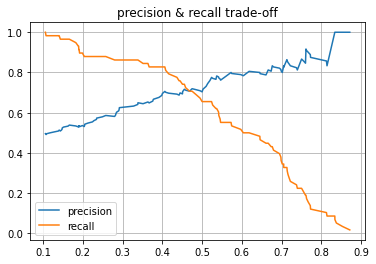

In [69]:
Y_prob = random_forest_grid.best_estimator_.predict_proba(X_test)[:, 1]

precision_array, recall_array, threshold_array = precision_recall_curve(Y_test, Y_prob)

plt.plot(threshold_array, precision_array[0:len(threshold_array)], label='precision')
plt.plot(threshold_array, recall_array[0:len(threshold_array)], label='recall')
plt.grid()
plt.title('precision & recall trade-off')
plt.legend(loc=0)

 - 위 글래프 결과, precision과 recall이 교차하는 지점은 Threshold가 0.4와 0.5사이에 있음을 알수 있다.


###### 이제 교차하는 지점을 찾아보자

In [70]:
cha_e = abs(np.array(precision_array) - np.array(recall_array))
cross_idx = np.argmin(cha_e)

threshold = threshold_array[cross_idx]

In [86]:
Y_prob

array([0.83765941, 0.28243259, 0.66071324, 0.01839133, 0.14349196,
       0.66624749, 0.53671357, 0.49494637, 0.64522676, 0.534779  ,
       0.77213554, 0.20455313, 0.14802209, 0.50004178, 0.71601621,
       0.01218074, 0.40631866, 0.01208894, 0.02122932, 0.51412484,
       0.70165031, 0.07828058, 0.33868784, 0.83382131, 0.75515064,
       0.20479582, 0.06134512, 0.1906765 , 0.47479002, 0.76705816,
       0.1629465 , 0.45544362, 0.6182381 , 0.22789216, 0.28500492,
       0.14798541, 0.69454126, 0.28332171, 0.12798691, 0.19909991,
       0.03300748, 0.1059627 , 0.16610361, 0.39150956, 0.10942727,
       0.7052642 , 0.67367855, 0.01448942, 0.10752754, 0.03965734,
       0.01950209, 0.01768939, 0.3514873 , 0.02563733, 0.14636894,
       0.09951662, 0.52662815, 0.43664344, 0.77279246, 0.54654881,
       0.46860746, 0.18241973, 0.64589313, 0.07185886, 0.25775185,
       0.02260862, 0.87143667, 0.22432135, 0.04935955, 0.2914205 ,
       0.20359319, 0.41606578, 0.76281459, 0.29195873, 0.54139

In [87]:
Y_prob >= threshold

array([ True, False,  True, False, False,  True,  True,  True,  True,
        True,  True, False, False,  True,  True, False, False, False,
       False,  True,  True, False, False,  True,  True, False, False,
       False,  True,  True, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True,  True, False,  True,
       False, False, False,  True, False, False, False, False, False,
        True, False,  True, False, False, False,  True, False, False,
        True, False,  True, False, False,  True, False,  True,  True,
       False,  True, False, False,  True, False,  True,  True, False,
       False, False,  True, False, False, False,  True, False,  True,
        True, False,  True, False,  True,  True, False, False, False,
        True, False,  True, False,  True,  True, False, False,  True,
        True,  True,

In [80]:
binatizer = Binarizer(threshold = threshold)
binatizer.fit(Y_prob)
binatizer.transform(Y_prob)

ValueError: Expected 2D array, got 1D array instead:
array=[0.83765941 0.28243259 0.66071324 0.01839133 0.14349196 0.66624749
 0.53671357 0.49494637 0.64522676 0.534779   0.77213554 0.20455313
 0.14802209 0.50004178 0.71601621 0.01218074 0.40631866 0.01208894
 0.02122932 0.51412484 0.70165031 0.07828058 0.33868784 0.83382131
 0.75515064 0.20479582 0.06134512 0.1906765  0.47479002 0.76705816
 0.1629465  0.45544362 0.6182381  0.22789216 0.28500492 0.14798541
 0.69454126 0.28332171 0.12798691 0.19909991 0.03300748 0.1059627
 0.16610361 0.39150956 0.10942727 0.7052642  0.67367855 0.01448942
 0.10752754 0.03965734 0.01950209 0.01768939 0.3514873  0.02563733
 0.14636894 0.09951662 0.52662815 0.43664344 0.77279246 0.54654881
 0.46860746 0.18241973 0.64589313 0.07185886 0.25775185 0.02260862
 0.87143667 0.22432135 0.04935955 0.2914205  0.20359319 0.41606578
 0.76281459 0.29195873 0.54139875 0.03629233 0.10399026 0.36381277
 0.71890037 0.18947405 0.45106929 0.76006943 0.18991476 0.81416165
 0.28004481 0.01589177 0.71331835 0.08691471 0.83399027 0.54528486
 0.01979365 0.50229568 0.18869312 0.40028742 0.7395337  0.06891112
 0.55950452 0.71411653 0.21299727 0.39849451 0.40847429 0.67653954
 0.04754078 0.0289193  0.02587364 0.67965835 0.01900833 0.85300981
 0.51970599 0.09571056 0.75021569 0.01166582 0.6987734  0.59722315
 0.45063789 0.09099498 0.04319017 0.72201619 0.32786001 0.52382678
 0.37594525 0.57279299 0.6037507  0.33822642 0.11782309 0.76123695
 0.54208423 0.51002607 0.24933966 0.23486199 0.0225687  0.44456412
 0.69816696 0.02134235 0.48503292 0.01987393 0.0886421  0.57436692
 0.15119439 0.29046199 0.81277896 0.44219986 0.14056845 0.04213899
 0.377402   0.23432963 0.36682091 0.73751251 0.45871042 0.01618376
 0.70526134 0.03017463 0.19185241 0.13874115].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.